In [1]:
import cv2
import numpy as np
from tqdm import tqdm
import nibabel as nb
import scipy.io
import scipy
from scipy import stats
import math
from scipy.stats import pearsonr
import pandas as pd
import statsmodels.api as sm

In [2]:
import cv2

cap = cv2.VideoCapture('D:/place_ROIs_project/movies/concat_movies.mp4')

ret, prev_frame = cap.read()
prev_frame = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

MaxDifEachSecond = np.zeros(3655)
MeanDifEachSecond = np.zeros(3655)
ArrayDifSecond = np.zeros(24)
FrameCounter = 1
SecondCounter = 0
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 4
Frame_num = []

for i in tqdm(range(2,total_frames+2)):
    
    ret, frame = cap.read()
    if not ret:
        break
    FrameCounter += 1
    if FrameCounter == 25:
        MaxDifEachSecond[SecondCounter] = ArrayDifSecond.max()
        MeanDifEachSecond[SecondCounter] = ArrayDifSecond.mean()
        FrameCounter = 1
        SecondCounter += 1
        
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Find the absolute difference between the current frame and the previous frame
    frame_diff = cv2.absdiff(frame_gray, prev_frame)
    ArrayDifSecond[FrameCounter-1] = frame_diff.flatten().mean()

    prev_frame = frame_gray

# Release the video capture object and close all windows
cap.release()
cv2.destroyAllWindows()


100%|████████████████████████████████████████████████████████████████████████████| 87720/87720 [18:40<00:00, 78.28it/s]


In [51]:
(MeanDifEachSecond > 25).any()

True

In [8]:
left_movie_data = scipy.io.loadmat('D:/FPP_project_analysis/Movie_watching_avg_data/notmean_left_Meanfile.mat')['Left_data']
right_movie_data = scipy.io.loadmat('D:/FPP_project_analysis/Movie_watching_avg_data/notmean_right_Meanfile.mat')['Right_data']

In [9]:
FPPs_right = (nb.load('D:/FPP_project_analysis/1_Finding_ROIs/sub_2/FPPs.rh.func.gii').darrays[0].data).T
FPPs_left = (nb.load('D:/FPP_project_analysis/1_Finding_ROIs/sub_2/FPPs.lh.func.gii').darrays[0].data).T

In [10]:
Right_FPPs_indices = [np.nonzero(FPPs_right[i]) for i in range(5)]
Left_FPPs_indices = [np.nonzero(FPPs_left[i]) for i in range(5)]

In [11]:
Activity_of_FPPs = [np.concatenate((right_movie_data[Right_FPPs_indices[i]], left_movie_data[Left_FPPs_indices[i]])) for i in range(5)]

In [12]:
Mean_FPPs_Activity = np.array([np.mean(Activity_of_FPPs[i], axis=0) for i in range(5)])

In [13]:
Mean_FPPs_Activity.shape

(5, 3655)

# exclude balnk seconds

In [14]:
HCPLabels = np.load('D:/place_ROIs_project/Phase5_AnalysisBasedOnPickActivityEachPatch/ShotScaleAnalysis/HCPLabels.npy',allow_pickle=True)
indexes_empty_lists = [index for index, lst in enumerate(HCPLabels) if lst == ['']]
indexes_empty_lists = np.array(indexes_empty_lists)

In [64]:
delay = 4
ShiftedMaxDifEachSecond = np.roll(MaxDifEachSecond, delay)
ShiftedMeanDifEachSecond = np.roll(MeanDifEachSecond, delay)

Shifted_indexes_empty_lists = (indexes_empty_lists + delay )%3655

In [65]:
Shifted_indexes_empty_lists = np.sort(Shifted_indexes_empty_lists)

In [66]:
NonBlankMask = np.ones(3655)
for index in Shifted_indexes_empty_lists:
        NonBlankMask[index] = 0
NonBlankMask = NonBlankMask==1

In [67]:
ShiftedMaxDifEachSecondNonBlank = ShiftedMaxDifEachSecond[NonBlankMask]
ShiftedMeanDifEachSecondNonBlank = ShiftedMeanDifEachSecond[NonBlankMask]

In [68]:
Mean_FPPs_Activity[0][NonBlankMask].shape

(3213,)

In [69]:
correlation_regressor_FPPs = np .zeros(5)
pvalue_regressor_FPPs = np.zeros(5)
for FPP in range(5):
    corr,p_value = stats.pearsonr(ShiftedMaxDifEachSecondNonBlank, Mean_FPPs_Activity[FPP][NonBlankMask])
    correlation_regressor_FPPs[FPP] = corr
    pvalue_regressor_FPPs[FPP] = p_value

In [70]:
correlation_regressor_FPPs

array([0.0030474 , 0.12274103, 0.11561811, 0.0880179 , 0.05722029])

In [71]:
pvalue_regressor_FPPs

array([8.62910965e-01, 2.92933351e-12, 4.92707665e-11, 5.82572947e-07,
       1.17519410e-03])

In [72]:
correlation_regressor_FPPs_with_blanks = np .zeros(5)
pvalue_regressor_FPPs_with_blanks = np.zeros(5)
for FPP in range(5):
    corr,p_value = stats.pearsonr(ShiftedMaxDifEachSecond, Mean_FPPs_Activity[FPP])
    correlation_regressor_FPPs_with_blanks[FPP] = corr
    pvalue_regressor_FPPs_with_blanks[FPP] = p_value

In [73]:
correlation_regressor_FPPs_with_blanks

array([-0.00368426,  0.18931148,  0.19067669,  0.16276262,  0.13173098])

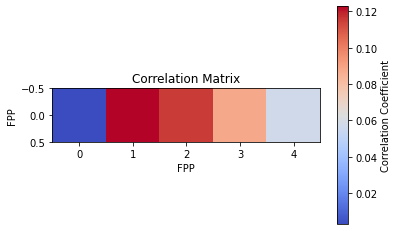

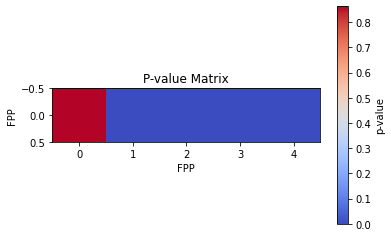

In [74]:

correlation = np.array([correlation_regressor_FPPs])
pvalue = np.array([pvalue_regressor_FPPs])


# Plot correlation matrix
plt.figure()
plt.imshow(correlation, cmap='coolwarm')
plt.colorbar(label='Correlation Coefficient')
plt.title('Correlation Matrix')
# plt.xticks(np.arange(5), np.arange(1, 6))
# plt.yticks(np.arange(5), np.arange(1, 6))
plt.xlabel('FPP')
plt.ylabel('FPP')
plt.show()

plt.imshow(pvalue, cmap='coolwarm')
plt.colorbar(label='p-value')
plt.title('P-value Matrix')
# plt.xticks(np.arange(5), np.arange(1, 6))
# plt.yticks(np.arange(5), np.arange(1, 6))
plt.xlabel('FPP')
plt.ylabel('FPP')
plt.show()


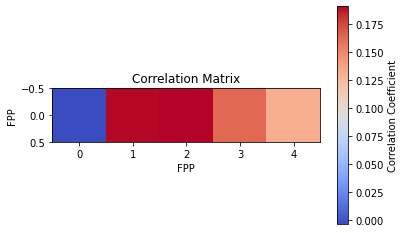

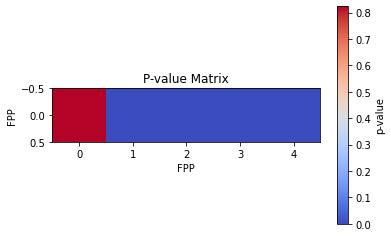

In [75]:

correlation_regressor_FPPs_with_blanks = np.array([correlation_regressor_FPPs_with_blanks])
pvalue_regressor_FPPs_with_blanks = np.array([pvalue_regressor_FPPs_with_blanks])


# Plot correlation matrix
plt.figure()
plt.imshow(correlation_regressor_FPPs_with_blanks, cmap='coolwarm')
plt.colorbar(label='Correlation Coefficient')
plt.title('Correlation Matrix')
# plt.xticks(np.arange(5), np.arange(1, 6))
# plt.yticks(np.arange(5), np.arange(1, 6))
plt.xlabel('FPP')
plt.ylabel('FPP')
plt.show()

plt.imshow(pvalue_regressor_FPPs_with_blanks, cmap='coolwarm')
plt.colorbar(label='p-value')
plt.title('P-value Matrix')
# plt.xticks(np.arange(5), np.arange(1, 6))
# plt.yticks(np.arange(5), np.arange(1, 6))
plt.xlabel('FPP')
plt.ylabel('FPP')
plt.show()
